# Creating an optimal Molecule's Potential Energy Curve using Adapt-VQE

A potential energy curve gives the ground energy of an assemble of atoms as function of the distances between them. The global minima of the curve indicates the binding energy and internuclear distance for the stable molecule. Therefor, such curve can be powerful tool in computational chemistry, for predicting molecular structure and spectrum.

In this tutorial, we will demonstrate how, using Classiq's VQE package, the user can create a Molecule's potential energy curve, and compare the result those of the Hartree-Fock approximative method and to the exact results. The exact solution is a result of diagonalizing the Hamiltonian.

## Main Idea
The main idea is to use the __qpe_for_molecules.ipynb__ notebook, but replace __qpe_flexible__ with __my_qpe_flexible__. Then, create an iterator function that uses this approach to find eigenvalues as part of an adapt-VQE implementation.

In [ ]:
#import time
import matplotlib.pyplot as plt
import numpy as np
import itertools
from classiq import *
from classiq.applications.chemistry import ChemistryExecutionParameters,HEAParameters,Molecule,MoleculeProblem,UCCParameters
from classiq.execution import OptimizerType
from classiq.applications.combinatorial_helpers.pauli_helpers.pauli_utils import pauli_operator_to_hamiltonian
from classiq.qmod.symbolic import ceiling as ceiling_qmod, pi
#authenticate(overwrite=True)

/home/dacc/anaconda3/lib/python3.12/site-packages/classiq/_internals/authentication/token_manager.py:93: UserWarning: Overwriting an existing refresh token should only be done if it is compromised. Make sure this operation is necessary, and if not, remove the call to device registration.
  warnings.warn(


Your user code: WBRV-SZTD
If a browser doesn't automatically open, please visit this URL from any trusted device: https://auth.classiq.io/activate?user_code=WBRV-SZTD
Abriendo en una sesión existente del navegador



## 0. Define Molecules
We start this defining some examples of molecular pairs and triplets.

In [36]:
num1, start1, stop1 = 7, 0.20, 1   #First Linear Space 
num2, start2, stop2 = 6, 1.4, 3  #Second Linear Space
distance = np.append(np.linspace(start1, stop1, num1), np.linspace(start2, stop2, num2)) # prepare x,y vectors
#molecules_LiH = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("Li", (0.0, 0.0, x))]) for x in distance]
#molecules_FH = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("F", (0.0, 0.0, x))]) for x in distance]
molecules_H2 = [Molecule(atoms=[("H", (0.0, 0.0, 0)), ("H", (0.0, 0.0, x))]) for x in distance]
#molecules_O2 = [Molecule(atoms=[("O", (0.0, 0.0, 0)), ("O", (0.0, 0.0, x))]) for x in distance]
#molecules_H2O = [Molecule(atoms=[("O", (0.0, 0.0, 0.0)), ("H", (0, x, y)), ("H", (0, x, -y))]) for (x,y) in itertools.product(distance,distance)]
#molecules_H3 = [Molecule(atoms=[("H", (0.0, 0.0, 0.0)), ("H", (0, x, y)), ("H", (0, x, -y))]) for (x,y)  in itertools.product(distance,distance)]
#molecules_O3 = [Molecule(atoms=[("O", (0.0, 0.0, 0.0)), ("O", (0, x, y)), ("O", (0, x, -y))]) for (x,y)  in itertools.product(distance,distance)]
#molecules_BeH2 = [Molecule(atoms=[("Be", (0.0, 0.0, 0.0)), ("H", (0, 0, x)), ("H", (0, 0, -x))]) for x in distance]

## 1. Vanilla VQE
This part would imitate the model of VQE already implemented on Classiq

In [37]:
VQE_energy, HF_energy, exact_energy = [],[],[]
qmods, qprogs, results, durations = [],[],[],[]
for k in range(len(distance)):
    molecule = molecules_H2[k]
    chemistry_problem = MoleculeProblem(molecule=molecule,mapping="jordan_wigner",z2_symmetries=True,freeze_core=True)  # jordan_wigner or bravyi_kitaev
    qmod = construct_chemistry_model(
        chemistry_problem=chemistry_problem,use_hartree_fock=True,ansatz_parameters=UCCParameters(excitations=[1, 2]),
        execution_parameters=ChemistryExecutionParameters(optimizer=OptimizerType.COBYLA,max_iteration=10,initial_point=None))
    qmods.append(qmod)
    qprog = synthesize(qmod);qprogs.append(qprog)
    result = execute(qprog).result();results.append(result)
    chemistry_result_dict = result[1].value
    operator = chemistry_problem.generate_hamiltonian()
    mat = operator.to_matrix()
    w, v = np.linalg.eig(mat)
    result_exact = np.real(min(w)) + chemistry_result_dict["nuclear_repulsion_energy"]
    VQE_energy.append(chemistry_result_dict["total_energy"])
    HF_energy.append(chemistry_result_dict["hartree_fock_energy"])
    exact_energy.append(result_exact)

This graph presents the ground state for $H_{2}$ molecule as a function of the distance between the two hydrogen atoms. One can see that both the HF solution and Classiq VQE present decent results around the global minima. For further distances, Classiq VQE stays close to the exact solution while the HF solution gradually deviates. The source of this lack of correspondence is with the lack of flexible correlations within the HF model, which is enabled within VQE scope.
One can similarly create graphs for different molecules (even n- dimensional or larger atom assemblies), to explore more curves.


# 2. Define Adapt_VQE using Flexible QPE

In [38]:
#Flexible QPE
@qfunc
def my_qpe_flexible(unitary: QCallable[CInt, QArray[QBit]],state: QArray[QBit],phase: QArray[QBit]) -> None:
    apply_to_all(H, phase)
    repeat(count=phase.len,iteration=lambda index: control(ctrl=phase[index],stmt_block=lambda: unitary(2**index, state)))
    invert(lambda: qft(phase),)

aVQE_energy=[]
for k in range(len(distance)):
    molecule = molecules_H2[k]
    gs_problem = MoleculeProblem(molecule=molecule,basis="sto3g",mapping="bravyi_kitaev",z2_symmetries=True,freeze_core=True) # jordan_wigner or bravyi_kitaev
    #print(gs_problem)
    
    #operator = gs_problem.generate_hamiltonian()
    #gs_problem = gs_problem.update_problem(operator.num_qubits)
    #mol_hamiltonian = pauli_operator_to_hamiltonian(operator.pauli_list)
    #problem_size = len(mol_hamiltonian[0].pauli)
    #print(f"The Hamiltonian is defined on {problem_size} qubits, and contains {len(mol_hamiltonian)} Pauli strings")
    #mat = hamiltonian_to_matrix(mol_hamiltonian)
    #w, v = np.linalg.eig(mat)
    #classical_sol = np.real(min(w))
    #coeiffs = [term.coefficient for term in mol_hamiltonian]
    #def trim_hamiltonian(hamiltonian, threshold):
    #    return [PauliTerm(pauli=term.pauli, coefficient=term.coefficient) for term in hamiltonian if np.abs(term.coefficient) > threshold]
    #THRESHOLD = 0.03
    #trimmed_mol_hamiltonian = trim_hamiltonian(mol_hamiltonian, THRESHOLD)
    #def normalize_hamiltonian(hamiltonian):
    #    approx_lambda_max = sum(np.abs(term.coefficient) for term in hamiltonian)
    #    normalization = 2 * approx_lambda_max
    #    normalized_mol_hamiltonian = [PauliTerm(pauli=term.pauli, coefficient=term.coefficient / (normalization)) for term in hamiltonian]
    #    return normalization, normalized_mol_hamiltonian
    #normalization, normalized_mol_hamiltonian = normalize_hamiltonian(trimmed_mol_hamiltonian)  #¿Cómo traspasar este hamiltoniano al comando que continúa el VQE?
 
    qmod = construct_chemistry_model(
        chemistry_problem=gs_problem,use_hartree_fock=True,ansatz_parameters=UCCParameters(excitations=[1, 2]),
        execution_parameters=ChemistryExecutionParameters(optimizer=OptimizerType.COBYLA,max_iteration=10,initial_point=None))
    preferences = Preferences(optimization_level=3)
    constraints= Constraints(max_depth=10, max_gate_count={TranspilerBasisGates.CX: 40})
    qmods.append(qmod)
    qprog = synthesize(qmod, constraints=constraints, preferences=preferences);qprogs.append(qprog)
    result = execute(qprog).result();results.append(result)
    chemistry_result_dict = result[1].value
    operator = chemistry_problem.generate_hamiltonian()
    mat = operator.to_matrix()
    w, v = np.linalg.eig(mat)
    result_exact = np.real(min(w)) + chemistry_result_dict["nuclear_repulsion_energy"]
    aVQE_energy.append(chemistry_result_dict["total_energy"])


## 3. Plot and comparing results

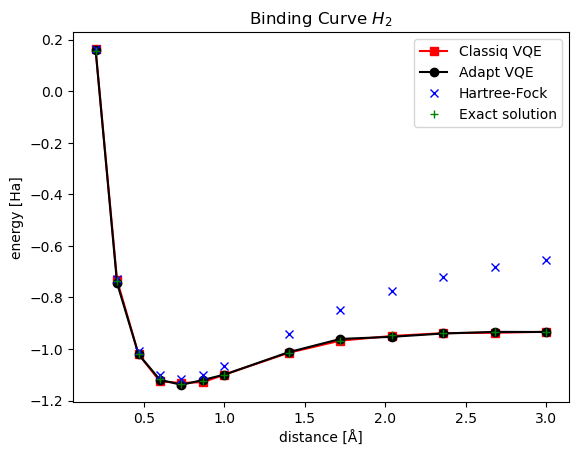

In [42]:
write_qmod(qmods[-1], "adapt_vqe_energy_curve") # save the last model to a qmod file
plt.plot(distance, VQE_energy, "r-s", distance, aVQE_energy, "k-o", distance, HF_energy, "bx", distance, exact_energy, "g+")
plt.xlabel(r"distance [Å]")
plt.ylabel("energy [Ha]")
plt.legend(["Classiq VQE", "Adapt VQE", "Hartree-Fock", "Exact solution"])
plt.title(r"Binding Curve $H_{2}$")
plt.show()

In [43]:
m1=min(VQE_energy); print(m1)
m2=min(aVQE_energy); print(m2)
m3=min(HF_energy); print(m3)
m4=min(exact_energy); print(m4)
print('----')
print(-100*np.abs(m1-m4)/m4)
print(-100*np.abs(m2-m4)/m4)
print(-100*np.abs(m3-m4)/m4)

-1.1318504550569797
-1.1389232660897268
-1.117069053137786
-1.137304045596478
----
0.4795191365593109
0.14237358070766207
1.7792069356510027
